In [1]:
import matplotlib.pyplot as plt
import numpy as np

from metanet_simulation import (
    METANETSimulation,
    build_uniform_metanet_mainline,
    METANETOnRampConfig,
)

%matplotlib inline

# Scenario a)

In [2]:
# Define time-varying demand (triangular profile)
def mainline_demand(step: int) -> float:
    """Ramp up, peak, then ramp down demand pattern."""
    peak = 4000.0  # Near capacity
    if step < 45:
        return peak * (step / 45)
    elif step <= 315:
        return peak
    elif step <= 360:
        return peak * (360 - step) / (360 - 315)
    else:
        return 0


# On-ramp with time-varying demand
def ramp_demand(step: int) -> float:
    """Rush hour pattern on the ramp."""
    peak = 2000.0
    if step < 90:
        return peak * (step / 90)
    elif step <= 270:
        return peak  # Heavy ramp demand
    elif step <= 360:
        return peak * (360 - step) / (360 - 270)
    else:
        return 0


cells = build_uniform_metanet_mainline(
    num_cells=6,
    cell_length_km=0.5,
    lanes=3,
    free_flow_speed_kmh=100.0,
    jam_density_veh_per_km_per_lane=180.0,
    tau_s=22.0,
    nu=15.0,
    kappa=10.0,
    delta=1.4,
)

ramp = METANETOnRampConfig(
    target_cell=2,
    arrival_rate_profile=ramp_demand,
    mainline_priority=0.5,
)

print(f"Created {len(cells)} cells with lane configuration: {[c.lanes for c in cells]}")
print(f"On-ramp merges at cell 2")
print(f"Mainline priority: {ramp.mainline_priority}")

# Create simulation
sim = METANETSimulation(
    cells=cells,
    time_step_hours=1 / 360,  # 3 minutes
    upstream_demand_profile=mainline_demand,  # veh/h
    on_ramps=[ramp],
)

# Run for 30 time steps
result = sim.run(steps=500)

# Print ramp statistics
ramp_name = list(result.ramp_queues.keys())[0]
max_queue = max(result.ramp_queues[ramp_name])
avg_queue = sum(result.ramp_queues[ramp_name]) / len(result.ramp_queues[ramp_name])
total_ramp_flow = sum(result.ramp_flows[ramp_name]) * result.time_step_hours

print(f"\nOn-ramp statistics:")
print(f"  Max queue: {max_queue:.1f} vehicles")
print(f"  Avg queue: {avg_queue:.1f} vehicles")
print(f"  Total vehicles merged: {total_ramp_flow:.0f} vehicles")

Created 6 cells with lane configuration: [3, 3, 3, 3, 3, 3]
On-ramp merges at cell 2
Mainline priority: 0.5

On-ramp statistics:
  Max queue: 0.0 vehicles
  Avg queue: 0.0 vehicles
  Total vehicles merged: 1750 vehicles


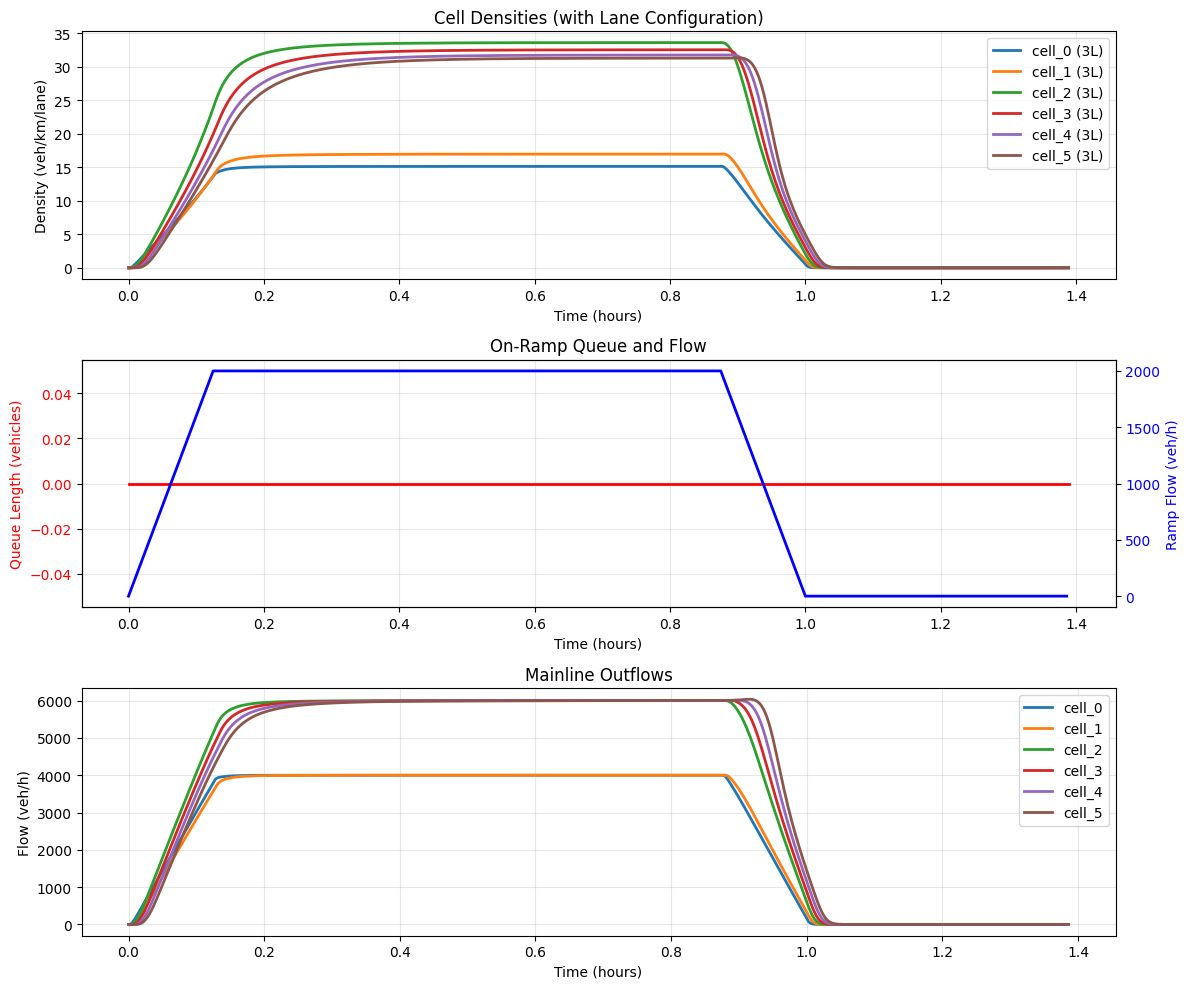

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

time = result.time_vector()

# Plot densities
ax = axes[0]
for idx, cell_name in enumerate(sorted(result.densities.keys())):
    lane_count = cells[idx].lanes
    label = f"{cell_name} ({lane_count}L)"
    ax.plot(time, result.densities[cell_name], label=label, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Density (veh/km/lane)')
ax.set_title('Cell Densities (with Lane Configuration)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot ramp queue and flow
ax = axes[1]
ax.plot(time, result.ramp_queues[ramp_name], 'r-', linewidth=2, label='Queue')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Queue Length (vehicles)', color='r')
ax.tick_params(axis='y', labelcolor='r')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
intervals = result.interval_vector()
interval_times = [t[0] for t in intervals]
ax2.plot(interval_times, result.ramp_flows[ramp_name], 'b-', linewidth=2, label='Flow')
ax2.set_ylabel('Ramp Flow (veh/h)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax.set_title('On-Ramp Queue and Flow')

# Plot mainline flows
ax = axes[2]
for cell_name in sorted(result.flows.keys()):
    ax.plot(interval_times, result.flows[cell_name], label=cell_name, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Flow (veh/h)')
ax.set_title('Mainline Outflows')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('outputs/scenario_a_metanet.png', dpi=300)
plt.show()

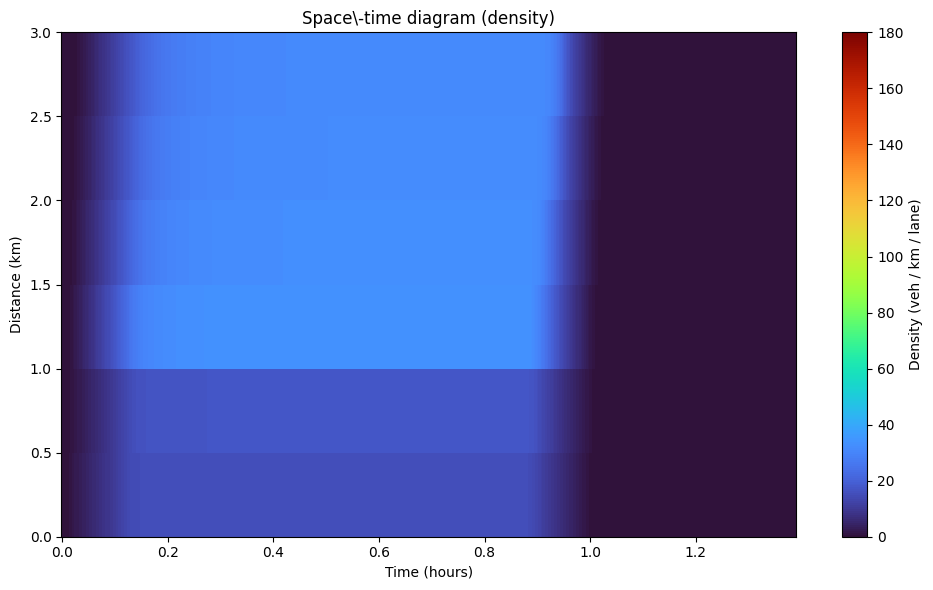

In [4]:
# time vector (hours)
time = np.asarray(result.time_vector())  # shape (T,)

# distances: cell center positions (km)
lengths = np.asarray([c.length_km for c in cells])
distance_km = np.cumsum(lengths) - 0.5 * lengths  # shape (N,)

# build density matrix Z with shape (T, N)
N = len(cells)
cols = []
for i in range(N):
    key = f"cell_{i}"
    if key in result.densities:
        cols.append(np.asarray(result.densities[key]))
    else:
        # fallback: use sorted order if naming differs
        cols = [np.asarray(result.densities[k]) for k in sorted(result.densities.keys())]
        break
Z = np.column_stack(cols)  # shape (T, N)

# mesh with time on x and distance on y; transpose Z to (N, T)
X, Y = np.meshgrid(time, distance_km)
fig, ax = plt.subplots(figsize=(10, 6))
pcm = ax.pcolormesh(X, Y, Z.T, shading="auto", cmap="turbo", vmin=0, vmax=180)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Distance (km)")
ax.set_title("Space\\-time diagram (density)")

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Density (veh / km / lane)")
plt.tight_layout()
plt.savefig('outputs/scenario_a_space_time_metanet.png', dpi=300)
plt.show()

In [5]:
dt = result.time_step_hours
lengths = np.asarray([c.length_km for c in cells])
lanes = np.asarray([c.lanes for c in cells])

cell_names = [f"cell_{i}" for i in range(len(cells))]
cols = [np.asarray(result.densities[name]) for name in cell_names]
D_all = np.column_stack(cols)

flows_matrix = np.column_stack([np.asarray(result.flows[name]) for name in cell_names])

vkt_per_step_per_cell = flows_matrix * dt * lengths
total_vkt = vkt_per_step_per_cell.sum()

T_plus1 = D_all.shape[0]
if T_plus1 >= 2:
    D = D_all[:-1, :]
else:
    D = D_all

vehicles_per_step_per_cell = D * lanes * lengths
vht_per_step_per_cell = vehicles_per_step_per_cell * dt
total_vht = vht_per_step_per_cell.sum()

print(f"Total VKT: {total_vkt:.1f} veh\u2009km")
print(f"Total VHT: {total_vht:.1f} veh\u2009h")

Total VKT: 14000.0 veh km
Total VHT: 203.2 veh h


# Scenario b)

In [6]:
# Define time-varying demand (triangular profile)
def mainline_demand(step: int) -> float:
    """Ramp up, peak, then ramp down demand pattern."""
    peak = 4000.0  # Near capacity
    if step < 45:
        return peak * (step / 45)
    elif step <= 315:
        return peak
    elif step <= 360:
        return peak * (360 - step) / (360 - 315)
    else:
        return 0


# On-ramp with time-varying demand
def ramp_demand(step: int) -> float:
    """Rush hour pattern on the ramp."""
    peak = 2500.0
    if step < 90:
        return peak * (step / 90)
    elif step <= 270:
        return peak  # Heavy ramp demand
    elif step <= 360:
        return peak * (360 - step) / (360 - 270)
    else:
        return 0


cells = build_uniform_metanet_mainline(
    num_cells=6,
    cell_length_km=0.5,
    lanes=3,
    capacity_veh_per_hour_per_lane=2000.0,
    free_flow_speed_kmh=100.0,
    jam_density_veh_per_km_per_lane=180.0,
    tau_s=22.0,
    nu=15.0,
    kappa=10.0,
    delta=1.4,
)

ramp = METANETOnRampConfig(
    target_cell=2,
    arrival_rate_profile=ramp_demand,
    mainline_priority=0.5,
)

print(f"Created {len(cells)} cells with lane configuration: {[c.lanes for c in cells]}")
print(f"On-ramp merges at cell 2")
print(f"Mainline priority: {ramp.mainline_priority}")

# Create simulation
sim = METANETSimulation(
    cells=cells,
    time_step_hours=1 / 360,  # 3 minutes
    upstream_demand_profile=mainline_demand,  # veh/h
    on_ramps=[ramp],
)

# Run for 30 time steps
result = sim.run(steps=500)

# Print ramp statistics
ramp_name = list(result.ramp_queues.keys())[0]
max_queue = max(result.ramp_queues[ramp_name])
avg_queue = sum(result.ramp_queues[ramp_name]) / len(result.ramp_queues[ramp_name])
total_ramp_flow = sum(result.ramp_flows[ramp_name]) * result.time_step_hours

print(f"\nOn-ramp statistics:")
print(f"  Max queue: {max_queue:.1f} vehicles")
print(f"  Avg queue: {avg_queue:.1f} vehicles")
print(f"  Total vehicles merged: {total_ramp_flow:.0f} vehicles")

Created 6 cells with lane configuration: [3, 3, 3, 3, 3, 3]
On-ramp merges at cell 2
Mainline priority: 0.5

On-ramp statistics:
  Max queue: 275.0 vehicles
  Avg queue: 90.2 vehicles
  Total vehicles merged: 1975 vehicles


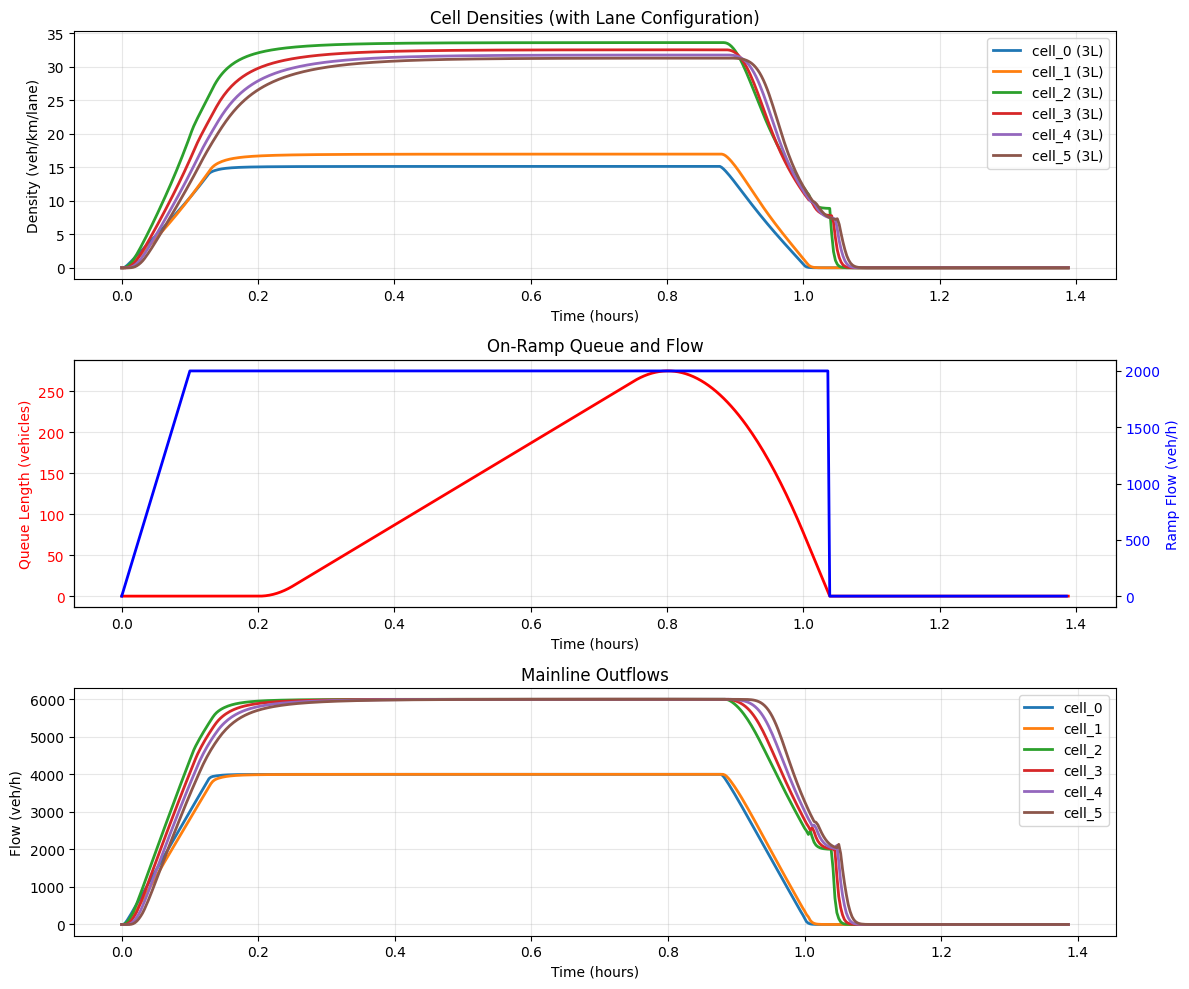

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

time = result.time_vector()

# Plot densities
ax = axes[0]
for idx, cell_name in enumerate(sorted(result.densities.keys())):
    lane_count = cells[idx].lanes
    label = f"{cell_name} ({lane_count}L)"
    ax.plot(time, result.densities[cell_name], label=label, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Density (veh/km/lane)')
ax.set_title('Cell Densities (with Lane Configuration)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot ramp queue and flow
ax = axes[1]
ax.plot(time, result.ramp_queues[ramp_name], 'r-', linewidth=2, label='Queue')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Queue Length (vehicles)', color='r')
ax.tick_params(axis='y', labelcolor='r')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
intervals = result.interval_vector()
interval_times = [t[0] for t in intervals]
ax2.plot(interval_times, result.ramp_flows[ramp_name], 'b-', linewidth=2, label='Flow')
ax2.set_ylabel('Ramp Flow (veh/h)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax.set_title('On-Ramp Queue and Flow')

# Plot mainline flows
ax = axes[2]
for cell_name in sorted(result.flows.keys()):
    ax.plot(interval_times, result.flows[cell_name], label=cell_name, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Flow (veh/h)')
ax.set_title('Mainline Outflows')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('outputs/scenario_b_metanet.png', dpi=300)
plt.show()

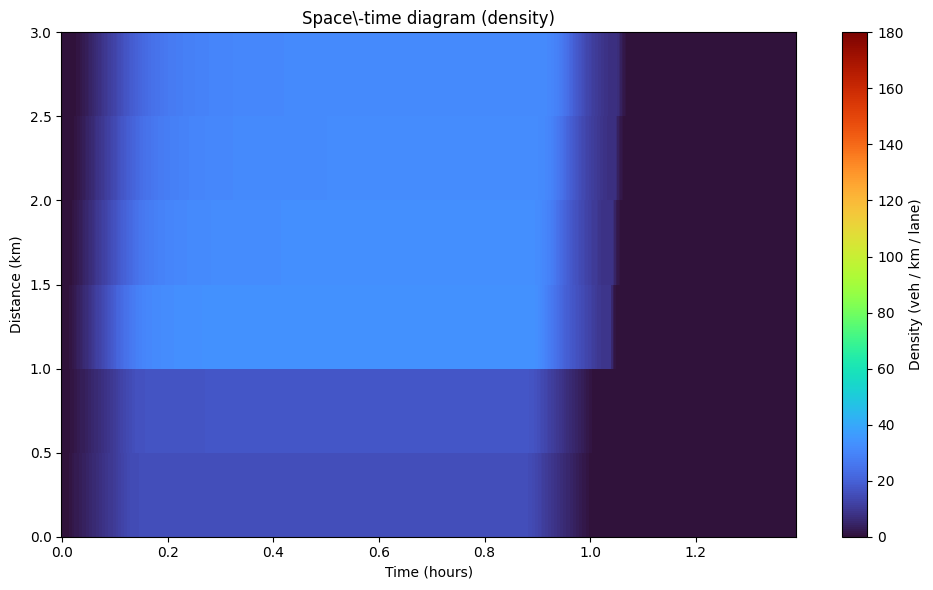

In [8]:
# time vector (hours)
time = np.asarray(result.time_vector())  # shape (T,)

# distances: cell center positions (km)
lengths = np.asarray([c.length_km for c in cells])
distance_km = np.cumsum(lengths) - 0.5 * lengths  # shape (N,)

# build density matrix Z with shape (T, N)
N = len(cells)
cols = []
for i in range(N):
    key = f"cell_{i}"
    if key in result.densities:
        cols.append(np.asarray(result.densities[key]))
    else:
        # fallback: use sorted order if naming differs
        cols = [np.asarray(result.densities[k]) for k in sorted(result.densities.keys())]
        break
Z = np.column_stack(cols)  # shape (T, N)

# mesh with time on x and distance on y; transpose Z to (N, T)
X, Y = np.meshgrid(time, distance_km)
fig, ax = plt.subplots(figsize=(10, 6))
pcm = ax.pcolormesh(X, Y, Z.T, shading="auto", cmap="turbo", vmin=0, vmax=180)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Distance (km)")
ax.set_title("Space\\-time diagram (density)")

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Density (veh / km / lane)")
plt.tight_layout()
plt.savefig('outputs/scenario_b_space_time_metanet.png', dpi=300)
plt.show()

In [9]:
dt = result.time_step_hours
lengths = np.asarray([c.length_km for c in cells])
lanes = np.asarray([c.lanes for c in cells])

cell_names = [f"cell_{i}" for i in range(len(cells))]
cols = [np.asarray(result.densities[name]) for name in cell_names]
D_all = np.column_stack(cols)

flows_matrix = np.column_stack([np.asarray(result.flows[name]) for name in cell_names])

vkt_per_step_per_cell = flows_matrix * dt * lengths
total_vkt = vkt_per_step_per_cell.sum()

T_plus1 = D_all.shape[0]
if T_plus1 >= 2:
    D = D_all[:-1, :]
else:
    D = D_all

vehicles_per_step_per_cell = D * lanes * lengths
vht_per_step_per_cell = vehicles_per_step_per_cell * dt
total_vht = vht_per_step_per_cell.sum()

print(f"Total VKT: {total_vkt:.1f} veh\u2009km")
print(f"Total VHT: {total_vht:.1f} veh\u2009h")

Total VKT: 14450.0 veh km
Total VHT: 210.1 veh h


# Scenario c)

In [28]:
# Define time-varying demand (triangular profile)
def mainline_demand(step: int) -> float:
    """Ramp up, peak, then ramp down demand pattern."""
    peak = 1500.0  # Near capacity
    if step < 45:
        return peak * (step / 45)
    elif step <= 315:
        return peak
    elif step <= 360:
        return peak * (360 - step) / (360 - 315)
    else:
        return 0


# On-ramp with time-varying demand
def ramp_demand(step: int) -> float:
    """Rush hour pattern on the ramp."""
    peak = 1500.0
    if step < 90:
        return peak * (step / 90)
    elif step <= 270:
        return peak  # Heavy ramp demand
    elif step <= 360:
        return peak * (360 - step) / (360 - 270)
    else:
        return 0


cells = build_uniform_metanet_mainline(
    num_cells=6,
    cell_length_km=0.5,
    lanes=[3, 3, 3, 3, 1, 3],
    capacity_veh_per_hour_per_lane=2000.0,
    free_flow_speed_kmh=100.0,
    jam_density_veh_per_km_per_lane=180.0,
    tau_s=22.0,
    nu=15.0,
    kappa=10.0,
    delta=1.4,
)

ramp = METANETOnRampConfig(
    target_cell=2,
    arrival_rate_profile=ramp_demand,
    mainline_priority=0.5,
)

print(f"Created {len(cells)} cells with lane configuration: {[c.lanes for c in cells]}")
print(f"On-ramp merges at cell 2")
print(f"Mainline priority: {ramp.mainline_priority}")

# Create simulation
sim = METANETSimulation(
    cells=cells,
    time_step_hours=1 / 360,  # 3 minutes
    upstream_demand_profile=mainline_demand,  # veh/h
    on_ramps=[ramp],
)

# Run for 30 time steps
result = sim.run(steps=500)

# Print ramp statistics
ramp_name = list(result.ramp_queues.keys())[0]
max_queue = max(result.ramp_queues[ramp_name])
avg_queue = sum(result.ramp_queues[ramp_name]) / len(result.ramp_queues[ramp_name])
total_ramp_flow = sum(result.ramp_flows[ramp_name]) * result.time_step_hours

print(f"\nOn-ramp statistics:")
print(f"  Max queue: {max_queue:.1f} vehicles")
print(f"  Avg queue: {avg_queue:.1f} vehicles")
print(f"  Total vehicles merged: {total_ramp_flow:.0f} vehicles")

Created 6 cells with lane configuration: [3, 3, 3, 3, 1, 3]
On-ramp merges at cell 2
Mainline priority: 0.5

On-ramp statistics:
  Max queue: 0.5 vehicles
  Avg queue: 0.0 vehicles
  Total vehicles merged: 1581 vehicles


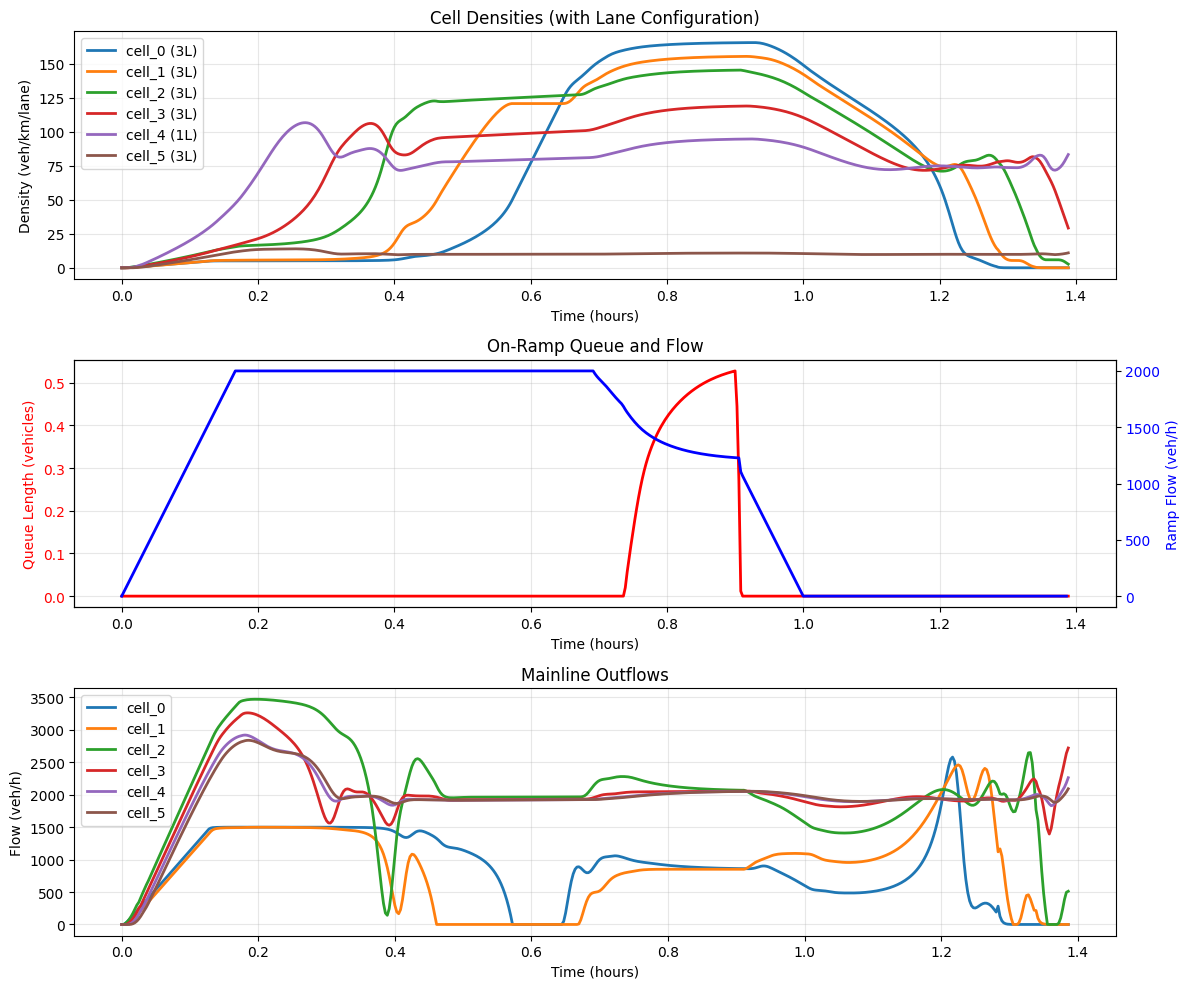

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

time = result.time_vector()

# Plot densities
ax = axes[0]
for idx, cell_name in enumerate(sorted(result.densities.keys())):
    lane_count = cells[idx].lanes
    label = f"{cell_name} ({lane_count}L)"
    ax.plot(time, result.densities[cell_name], label=label, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Density (veh/km/lane)')
ax.set_title('Cell Densities (with Lane Configuration)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot ramp queue and flow
ax = axes[1]
ax.plot(time, result.ramp_queues[ramp_name], 'r-', linewidth=2, label='Queue')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Queue Length (vehicles)', color='r')
ax.tick_params(axis='y', labelcolor='r')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
intervals = result.interval_vector()
interval_times = [t[0] for t in intervals]
ax2.plot(interval_times, result.ramp_flows[ramp_name], 'b-', linewidth=2, label='Flow')
ax2.set_ylabel('Ramp Flow (veh/h)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax.set_title('On-Ramp Queue and Flow')

# Plot mainline flows
ax = axes[2]
for cell_name in sorted(result.flows.keys()):
    ax.plot(interval_times, result.flows[cell_name], label=cell_name, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Flow (veh/h)')
ax.set_title('Mainline Outflows')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('outputs/scenario_c_metanet.png', dpi=300)
plt.show()

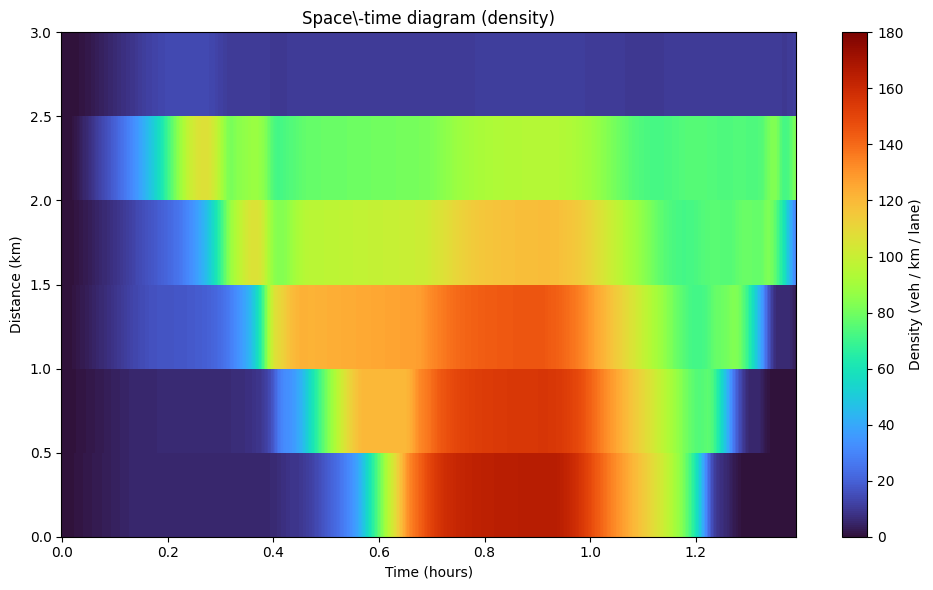

In [30]:
# time vector (hours)
time = np.asarray(result.time_vector())  # shape (T,)

# distances: cell center positions (km)
lengths = np.asarray([c.length_km for c in cells])
distance_km = np.cumsum(lengths) - 0.5 * lengths  # shape (N,)

# build density matrix Z with shape (T, N)
N = len(cells)
cols = []
for i in range(N):
    key = f"cell_{i}"
    if key in result.densities:
        cols.append(np.asarray(result.densities[key]))
    else:
        # fallback: use sorted order if naming differs
        cols = [np.asarray(result.densities[k]) for k in sorted(result.densities.keys())]
        break
Z = np.column_stack(cols)  # shape (T, N)

# mesh with time on x and distance on y; transpose Z to (N, T)
X, Y = np.meshgrid(time, distance_km)
fig, ax = plt.subplots(figsize=(10, 6))
pcm = ax.pcolormesh(X, Y, Z.T, shading="auto", cmap="turbo", vmin=0, vmax=180)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Distance (km)")
ax.set_title("Space\\-time diagram (density)")

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Density (veh / km / lane)")
plt.tight_layout()
plt.savefig('outputs/scenario_c_space_time_metanet.png', dpi=300)
plt.show()

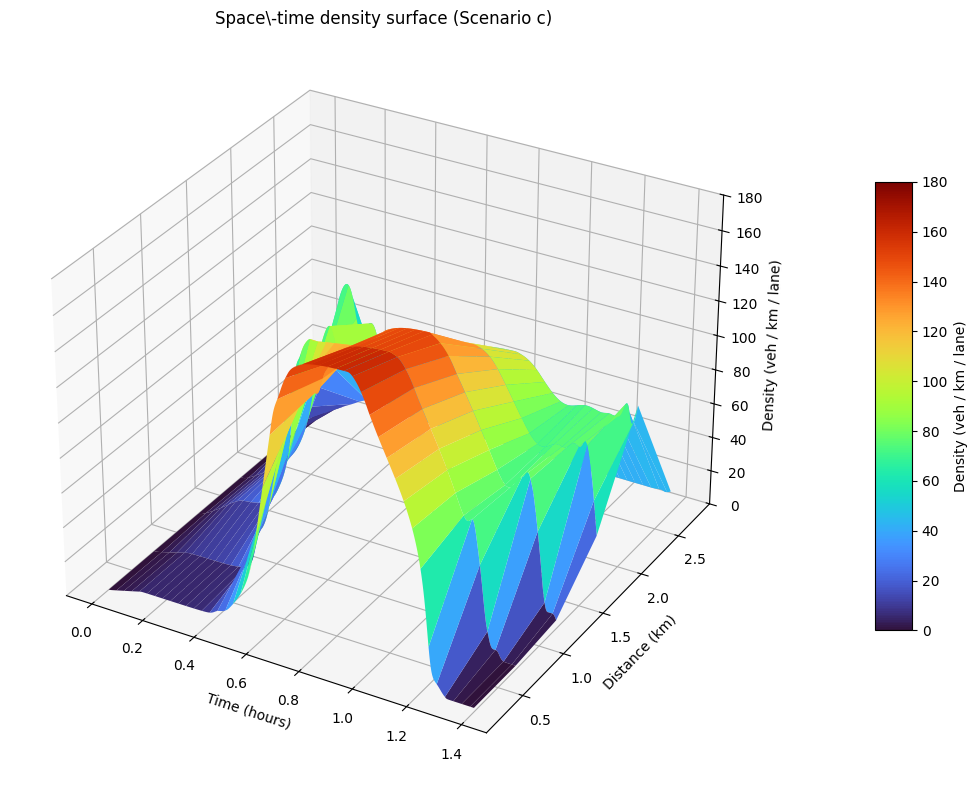

In [31]:
# ensure X, Y match the density matrix shape
X, Y = np.meshgrid(time, distance_km)  # shapes (N, T)
assert X.shape == Z.T.shape, "meshgrid shape and Z.T shape must match"

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# plot the surface (time on x, distance on y, density on z)
surf = ax.plot_surface(
    X, Y, Z.T,
    cmap="turbo",
    linewidth=0,
    antialiased=True,
    vmin=0,
    vmax=180,
)

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Distance (km)")
ax.set_zlabel("Density (veh / km / lane)")
ax.set_title("Space\\-time density surface (Scenario c)")

# colorbar for the surface
cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12, pad=0.1)
cbar.set_label("Density (veh / km / lane)")

# enforce z range and set a good view angle
ax.set_zlim(0, 180)
ax.view_init(elev=30, azim=-60)

plt.tight_layout()
plt.savefig('outputs/scenario_c_space_time_metanet_3d.png', dpi=300)
plt.show()

In [32]:
dt = result.time_step_hours
lengths = np.asarray([c.length_km for c in cells])
lanes = np.asarray([c.lanes for c in cells])

cell_names = [f"cell_{i}" for i in range(len(cells))]
cols = [np.asarray(result.densities[name]) for name in cell_names]
D_all = np.column_stack(cols)

flows_matrix = np.column_stack([np.asarray(result.flows[name]) for name in cell_names])

vkt_per_step_per_cell = flows_matrix * dt * lengths
total_vkt = vkt_per_step_per_cell.sum()

T_plus1 = D_all.shape[0]
if T_plus1 >= 2:
    D = D_all[:-1, :]
else:
    D = D_all

vehicles_per_step_per_cell = D * lanes * lengths
vht_per_step_per_cell = vehicles_per_step_per_cell * dt
total_vht = vht_per_step_per_cell.sum()

print(f"Total VKT: {total_vkt:.1f} veh\u2009km")
print(f"Total VHT: {total_vht:.1f} veh\u2009h")

Total VKT: 6693.1 veh km
Total VHT: 702.8 veh h


# Scenario b) with ALINEA

In [15]:
# Define time-varying demand (triangular profile)
def mainline_demand(step: int) -> float:
    """Ramp up, peak, then ramp down demand pattern."""
    peak = 4000.0  # Near capacity
    if step < 45:
        return peak * (step / 45)
    elif step <= 315:
        return peak
    elif step <= 360:
        return peak * (360 - step) / (360 - 315)
    else:
        return 0


# On-ramp with time-varying demand
def ramp_demand(step: int) -> float:
    """Rush hour pattern on the ramp."""
    peak = 2500.0
    if step < 90:
        return peak * (step / 90)
    elif step <= 270:
        return peak  # Heavy ramp demand
    elif step <= 360:
        return peak * (360 - step) / (360 - 270)
    else:
        return 0


cells = build_uniform_metanet_mainline(
    num_cells=6,
    cell_length_km=0.5,
    lanes=3,
    capacity_veh_per_hour_per_lane=2000.0,
    free_flow_speed_kmh=100.0,
    jam_density_veh_per_km_per_lane=180.0,
    tau_s=22.0,
    nu=15.0,
    kappa=10.0,
    delta=1.4,
)

ramp = METANETOnRampConfig(
    target_cell=2,
    arrival_rate_profile=ramp_demand,
    meter_rate_veh_per_hour=60000.0,
    alinea_enabled=True,
    alinea_target_density=20.0,
    alinea_gain=40.0,
    alinea_measurement_cell=3,
    alinea_max_rate=2000.0,
    alinea_min_rate=0.0,
)

print(f"Created {len(cells)} cells with lane configuration: {[c.lanes for c in cells]}")
print(f"On-ramp merges at cell 2")
print(f"ALINEA gain: {ramp.alinea_gain}")

# Create simulation
sim = METANETSimulation(
    cells=cells,
    time_step_hours=1 / 360,
    upstream_demand_profile=mainline_demand,  # veh/h
    on_ramps=[ramp],
)

# Run for 30 time steps
result = sim.run(steps=500)

# Print ramp statistics
ramp_name = list(result.ramp_queues.keys())[0]
max_queue = max(result.ramp_queues[ramp_name])
avg_queue = sum(result.ramp_queues[ramp_name]) / len(result.ramp_queues[ramp_name])
total_ramp_flow = sum(result.ramp_flows[ramp_name]) * result.time_step_hours

print(f"\nOn-ramp statistics:")
print(f"  Max queue: {max_queue:.1f} vehicles")
print(f"  Avg queue: {avg_queue:.1f} vehicles")
print(f"  Total vehicles merged: {total_ramp_flow:.0f} vehicles")

Created 6 cells with lane configuration: [3, 3, 3, 3, 3, 3]
On-ramp merges at cell 2
ALINEA gain: 40.0

On-ramp statistics:
  Max queue: 1067.5 vehicles
  Avg queue: 533.1 vehicles
  Total vehicles merged: 1785 vehicles


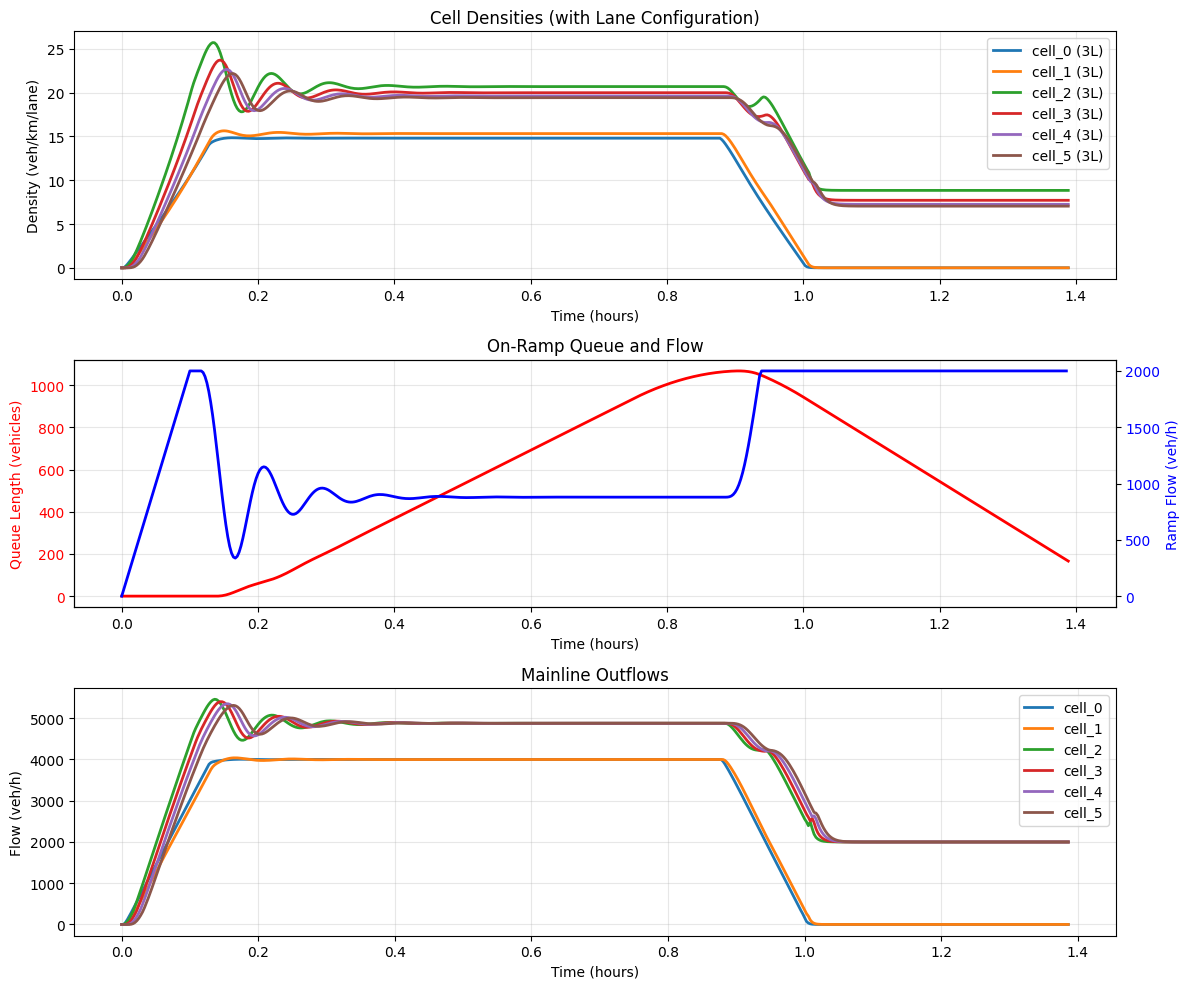

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

time = result.time_vector()

# Plot densities
ax = axes[0]
for idx, cell_name in enumerate(sorted(result.densities.keys())):
    lane_count = cells[idx].lanes
    label = f"{cell_name} ({lane_count}L)"
    ax.plot(time, result.densities[cell_name], label=label, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Density (veh/km/lane)')
ax.set_title('Cell Densities (with Lane Configuration)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot ramp queue and flow
ax = axes[1]
ax.plot(time, result.ramp_queues[ramp_name], 'r-', linewidth=2, label='Queue')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Queue Length (vehicles)', color='r')
ax.tick_params(axis='y', labelcolor='r')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
intervals = result.interval_vector()
interval_times = [t[0] for t in intervals]
ax2.plot(interval_times, result.ramp_flows[ramp_name], 'b-', linewidth=2, label='Flow')
ax2.set_ylabel('Ramp Flow (veh/h)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax.set_title('On-Ramp Queue and Flow')

# Plot mainline flows
ax = axes[2]
for cell_name in sorted(result.flows.keys()):
    ax.plot(interval_times, result.flows[cell_name], label=cell_name, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Flow (veh/h)')
ax.set_title('Mainline Outflows')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/scenario_b_alinea_metanet.png', dpi=300)
plt.show()

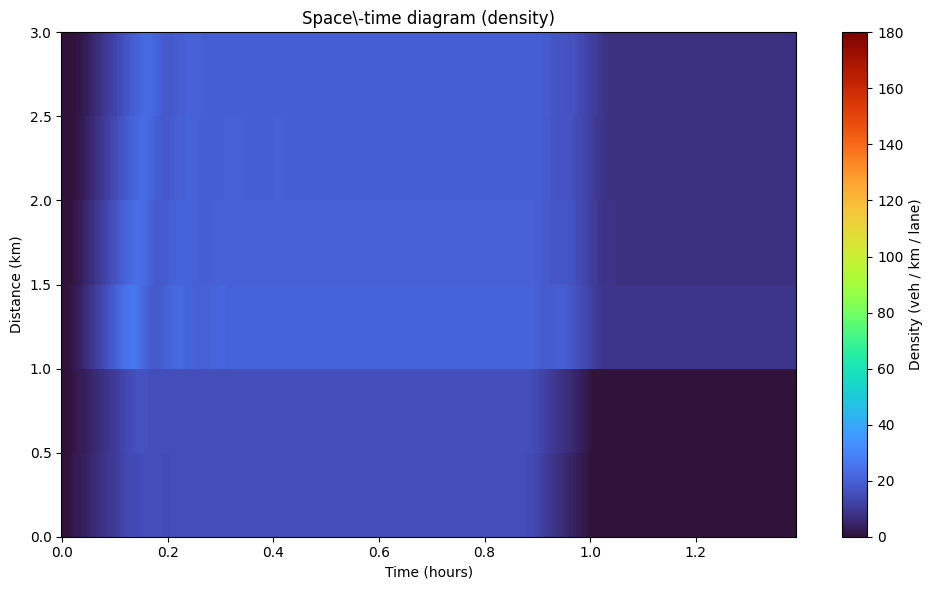

In [17]:
# time vector (hours)
time = np.asarray(result.time_vector())  # shape (T,)

# distances: cell center positions (km)
lengths = np.asarray([c.length_km for c in cells])
distance_km = np.cumsum(lengths) - 0.5 * lengths  # shape (N,)

# build density matrix Z with shape (T, N)
N = len(cells)
cols = []
for i in range(N):
    key = f"cell_{i}"
    if key in result.densities:
        cols.append(np.asarray(result.densities[key]))
    else:
        # fallback: use sorted order if naming differs
        cols = [np.asarray(result.densities[k]) for k in sorted(result.densities.keys())]
        break
Z = np.column_stack(cols)  # shape (T, N)

# mesh with time on x and distance on y; transpose Z to (N, T)
X, Y = np.meshgrid(time, distance_km)
fig, ax = plt.subplots(figsize=(10, 6))
pcm = ax.pcolormesh(X, Y, Z.T, shading="auto", cmap="turbo", vmin=0, vmax=180)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Distance (km)")
ax.set_title("Space\\-time diagram (density)")
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Density (veh / km / lane)")
plt.tight_layout()
plt.savefig('outputs/scenario_b_alinea_space_time_metanet.png', dpi=300)
plt.show()

In [18]:
dt = result.time_step_hours
lengths = np.asarray([c.length_km for c in cells])
lanes = np.asarray([c.lanes for c in cells])

cell_names = [f"cell_{i}" for i in range(len(cells))]
cols = [np.asarray(result.densities[name]) for name in cell_names]
D_all = np.column_stack(cols)

flows_matrix = np.column_stack([np.asarray(result.flows[name]) for name in cell_names])

vkt_per_step_per_cell = flows_matrix * dt * lengths
total_vkt = vkt_per_step_per_cell.sum()

T_plus1 = D_all.shape[0]
if T_plus1 >= 2:
    D = D_all[:-1, :]
else:
    D = D_all

vehicles_per_step_per_cell = D * lanes * lengths
vht_per_step_per_cell = vehicles_per_step_per_cell * dt
total_vht = vht_per_step_per_cell.sum()

print(f"Total VKT: {total_vkt:.1f} veh\u2009km")
print(f"Total VHT: {total_vht:.1f} veh\u2009h")

Total VKT: 14010.1 veh km
Total VHT: 167.1 veh h


# Scenario c) with ALINEA

In [19]:
# Define time-varying demand (triangular profile)
def mainline_demand(step: int) -> float:
    """Ramp up, peak, then ramp down demand pattern."""
    peak = 1500.0  # Near capacity
    if step < 45:
        return peak * (step / 45)
    elif step <= 315:
        return peak
    elif step <= 360:
        return peak * (360 - step) / (360 - 315)
    else:
        return 0


# On-ramp with time-varying demand
def ramp_demand(step: int) -> float:
    """Rush hour pattern on the ramp."""
    peak = 1500.0
    if step < 90:
        return peak * (step / 90)
    elif step <= 270:
        return peak  # Heavy ramp demand
    elif step <= 360:
        return peak * (360 - step) / (360 - 270)
    else:
        return 0


cells = build_uniform_metanet_mainline(
    num_cells=6,
    cell_length_km=0.5,
    lanes=[3, 3, 3, 3, 1, 3],
    capacity_veh_per_hour_per_lane=2000.0,
    free_flow_speed_kmh=100.0,
    jam_density_veh_per_km_per_lane=180.0,
    tau_s=22.0,
    nu=15.0,
    kappa=10.0,
    delta=1.4,
)

ramp = METANETOnRampConfig(
    target_cell=2,
    arrival_rate_profile=ramp_demand,
    meter_rate_veh_per_hour=0.0,
    alinea_enabled=True,
    alinea_gain=15.0,
    alinea_target_density=20.0,
    alinea_measurement_cell=4,
    alinea_min_rate=0.0,
    alinea_max_rate=2000.0,
)

print(f"Created {len(cells)} cells with lane configuration: {[c.lanes for c in cells]}")
print(f"On-ramp merges at cell 2")
print(f"ALINEA gain: {ramp.alinea_gain}")

# Create simulation
sim = METANETSimulation(
    cells=cells,
    time_step_hours=1 / 360,  # 3 minutes
    upstream_demand_profile=mainline_demand,
    downstream_supply_profile=20000.0,  # veh/h
    on_ramps=[ramp],
)

# Run for 30 time steps
result = sim.run(steps=500)

# Print ramp statistics
ramp_name = list(result.ramp_queues.keys())[0]
max_queue = max(result.ramp_queues[ramp_name])
avg_queue = sum(result.ramp_queues[ramp_name]) / len(result.ramp_queues[ramp_name])
total_ramp_flow = sum(result.ramp_flows[ramp_name]) * result.time_step_hours

print(f"\nOn-ramp statistics:")
print(f"  Max queue: {max_queue:.1f} vehicles")
print(f"  Avg queue: {avg_queue:.1f} vehicles")
print(f"  Total vehicles merged: {total_ramp_flow:.0f} vehicles")

Created 6 cells with lane configuration: [3, 3, 3, 3, 1, 3]
On-ramp merges at cell 2
ALINEA gain: 15.0

On-ramp statistics:
  Max queue: 815.9 vehicles
  Avg queue: 405.6 vehicles
  Total vehicles merged: 1092 vehicles


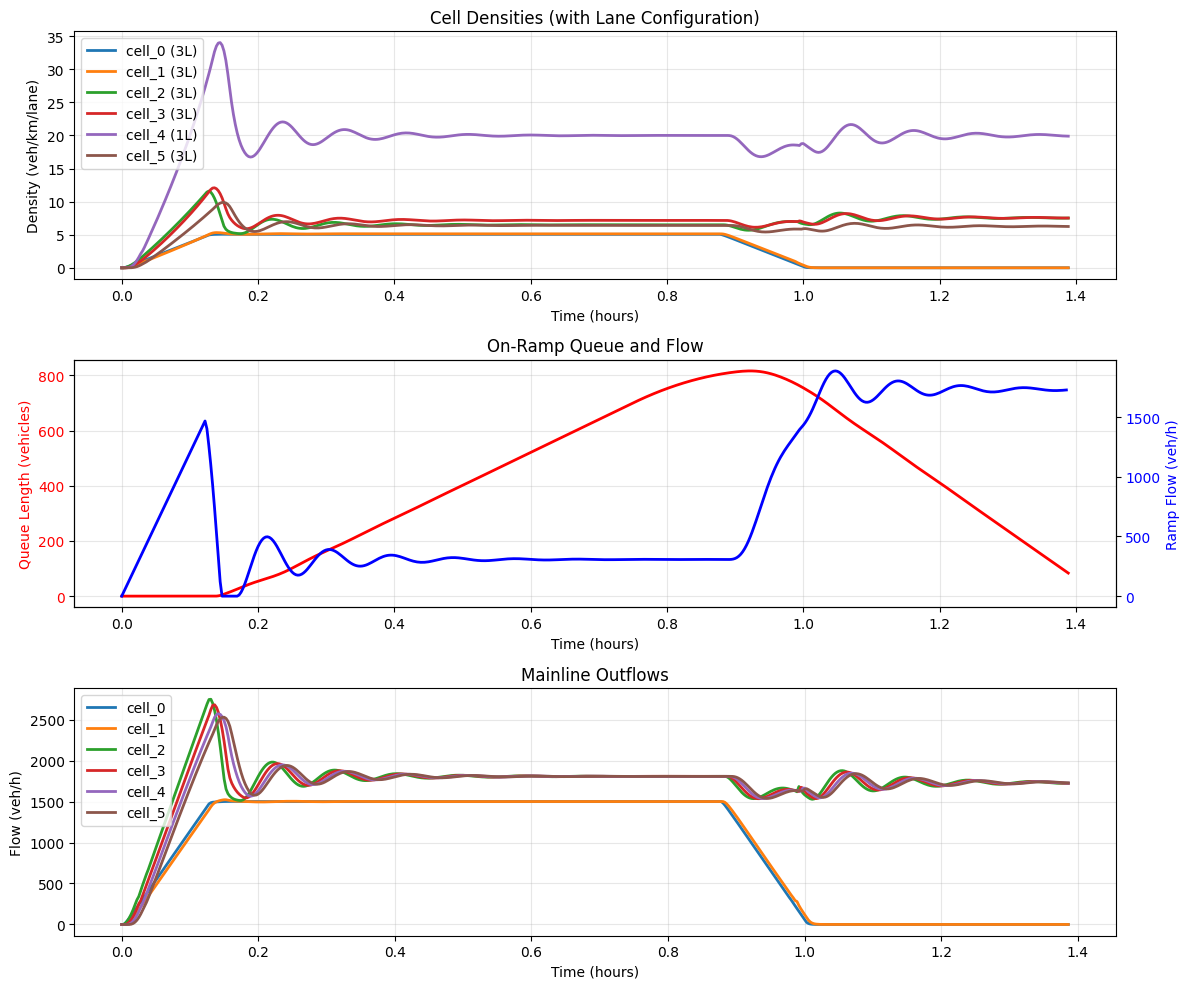

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

time = result.time_vector()

# Plot densities
ax = axes[0]
for idx, cell_name in enumerate(sorted(result.densities.keys())):
    lane_count = cells[idx].lanes
    label = f"{cell_name} ({lane_count}L)"
    ax.plot(time, result.densities[cell_name], label=label, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Density (veh/km/lane)')
ax.set_title('Cell Densities (with Lane Configuration)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot ramp queue and flow
ax = axes[1]
ax.plot(time, result.ramp_queues[ramp_name], 'r-', linewidth=2, label='Queue')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Queue Length (vehicles)', color='r')
ax.tick_params(axis='y', labelcolor='r')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
intervals = result.interval_vector()
interval_times = [t[0] for t in intervals]
ax2.plot(interval_times, result.ramp_flows[ramp_name], 'b-', linewidth=2, label='Flow')
ax2.set_ylabel('Ramp Flow (veh/h)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax.set_title('On-Ramp Queue and Flow')

# Plot mainline flows
ax = axes[2]
for cell_name in sorted(result.flows.keys()):
    ax.plot(interval_times, result.flows[cell_name], label=cell_name, linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Flow (veh/h)')
ax.set_title('Mainline Outflows')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/scenario_c_alinea_metanet.png', dpi=300)
plt.show()

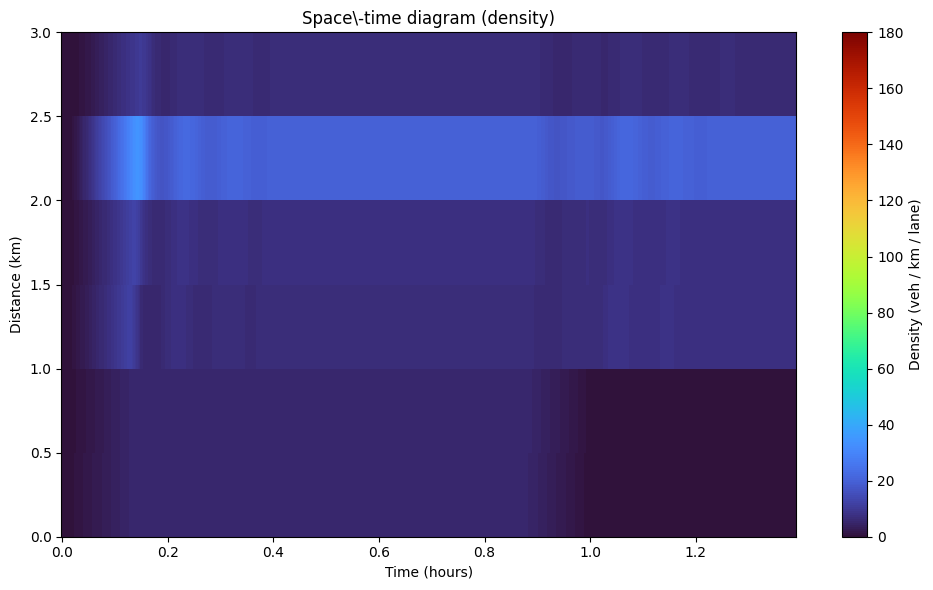

In [21]:
# time vector (hours)
time = np.asarray(result.time_vector())  # shape (T,)

# distances: cell center positions (km)
lengths = np.asarray([c.length_km for c in cells])
distance_km = np.cumsum(lengths) - 0.5 * lengths  # shape (N,)

# build density matrix Z with shape (T, N)
N = len(cells)
cols = []
for i in range(N):
    key = f"cell_{i}"
    if key in result.densities:
        cols.append(np.asarray(result.densities[key]))
    else:
        # fallback: use sorted order if naming differs
        cols = [np.asarray(result.densities[k]) for k in sorted(result.densities.keys())]
        break
Z = np.column_stack(cols)  # shape (T, N)

# mesh with time on x and distance on y; transpose Z to (N, T)
X, Y = np.meshgrid(time, distance_km)
fig, ax = plt.subplots(figsize=(10, 6))
pcm = ax.pcolormesh(X, Y, Z.T, shading="auto", cmap="turbo", vmin=0, vmax=180)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Distance (km)")
ax.set_title("Space\\-time diagram (density)")
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Density (veh / km / lane)")
plt.tight_layout()
plt.savefig('outputs/scenario_c_alinea_space_time_metanet.png', dpi=300)
plt.show()

In [22]:
dt = result.time_step_hours
lengths = np.asarray([c.length_km for c in cells])
lanes = np.asarray([c.lanes for c in cells])

cell_names = [f"cell_{i}" for i in range(len(cells))]
cols = [np.asarray(result.densities[name]) for name in cell_names]
D_all = np.column_stack(cols)

flows_matrix = np.column_stack([np.asarray(result.flows[name]) for name in cell_names])

vkt_per_step_per_cell = flows_matrix * dt * lengths
total_vkt = vkt_per_step_per_cell.sum()

T_plus1 = D_all.shape[0]
if T_plus1 >= 2:
    D = D_all[:-1, :]
else:
    D = D_all

vehicles_per_step_per_cell = D * lanes * lengths
vht_per_step_per_cell = vehicles_per_step_per_cell * dt
total_vht = vht_per_step_per_cell.sum()

print(f"Total VKT: {total_vkt:.1f} veh\u2009km")
print(f"Total VHT: {total_vht:.1f} veh\u2009h")

Total VKT: 6066.9 veh km
Total VHT: 68.0 veh h
